In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# Define IoU metric
def iou_metric(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(np.float32)
    intersection = np.sum(y_true * y_pred_binary)
    union = np.sum(y_true) + np.sum(y_pred_binary) - intersection
    return intersection / union

# Define Jaccard Index
def jaccard_index(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(np.int32)
    return jaccard_score(y_true.flatten(), y_pred_binary.flatten())

# Define Dice Coefficient
def dice_coefficient(y_true, y_pred):
    y_pred_binary = (y_pred > 0.5).astype(np.float32)
    intersection = np.sum(y_true * y_pred_binary)
    return 2 * intersection / (np.sum(y_true) + np.sum(y_pred_binary))

# Define U-Net model
def unet_model(input_shape=(256, 256, 3)):
    inputs = layers.Input(input_shape)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)

    u2 = layers.UpSampling2D((2, 2))(c3)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u2)
    c4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c4)

    u1 = layers.UpSampling2D((2, 2))(c4)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)
    model = Model(inputs, outputs)
    return model


In [2]:
# Load data
def load_data(image_dir, mask_dir, image_size=(256, 256)):
    image_files = os.listdir(image_dir)
    mask_files = os.listdir(mask_dir)
    images, masks = [], []
    for img_file, mask_file in zip(image_files, mask_files):
        img = load_img(os.path.join(image_dir, img_file), target_size=image_size, color_mode='rgb')
        mask = load_img(os.path.join(mask_dir, mask_file), target_size=image_size, color_mode='grayscale')
        images.append(img_to_array(img) / 255.0)
        masks.append(img_to_array(mask) / 255.0)
    return np.array(images), np.array(masks)

In [3]:
# Paths to dataset
image_dir = 'C:/Users/YELLEPEDDI KRISHNA/Desktop/U-net/COVID'
mask_dir = 'C:/Users/YELLEPEDDI KRISHNA/Desktop/U-net/Masked'

# Load images and masks
images, masks = load_data(image_dir, mask_dir)

# Compile and train the model
model = unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(images, masks, epochs=20, batch_size=32)

Epoch 1/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1201s 30s/step - accuracy: 0.0000e+00 - loss: 0.7561
Epoch 2/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1242s 31s/step - accuracy: 0.0000e+00 - loss: 0.6498
Epoch 3/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1265s 32s/step - accuracy: 0.0000e+00 - loss: 0.6439
Epoch 4/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1254s 31s/step - accuracy: 0.0000e+00 - loss: 0.6431
Epoch 5/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1251s 31s/step - accuracy: 0.0000e+00 - loss: 0.6431
Epoch 6/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1234s 31s/step - accuracy: 0.0000e+00 - loss: 0.6409
Epoch 7/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1227s 31s/step - accuracy: 0.0000e+00 - loss: 0.6409
Epoch 8/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1241s 31s/step - accuracy: 0.0000e+00 - loss: 0.6393
Epoch 9/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1228s 31s/step - accuracy: 0.0000e+00 - loss: 0.6428
Epoch 10/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1230s 31s/step - accuracy: 0.0000e+00 - loss: 0.6410
Epoch 11/20
40/40 ━━━━━━━━━━━━━━━━━━━━ 1252s 31s/step - accuracy: 0.0000e+00 - loss: 0.63

In [4]:
# Visualize predictions
def visualize_prediction(image, mask, pred_mask, infected_threshold=0.5):
    pred_mask_rgb = np.zeros((*pred_mask.shape[:2], 3))
    pred_mask_rgb[:, :, 2] = (pred_mask < infected_threshold).astype(np.float32)  # Blue
    pred_mask_rgb[:, :, 1] = (pred_mask >= infected_threshold).astype(np.float32)  # Green
    pred_mask_rgb[:, :, 0] = (mask.squeeze() > 0.5).astype(np.float32)  # Red

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap="Blues", alpha=0.6)
    plt.title("True Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(image)
    plt.imshow(pred_mask_rgb, alpha=0.6)
    plt.title("Predicted Mask")
    plt.axis("off")
    plt.show()

In [6]:
# Threshold predictions to binary values
binary_predictions = (predictions > 0.5).astype(np.int32)

# Evaluate the model on IoU, Jaccard Index, and Dice Coefficient
iou_scores = [iou_metric(mask, pred) for mask, pred in zip(masks, binary_predictions)]
jaccard_scores = [jaccard_index(mask.astype(np.int32), pred) for mask, pred in zip(masks, binary_predictions)]
dice_scores = [dice_coefficient(mask, pred) for mask, pred in zip(masks, binary_predictions)]

# Print the evaluation metrics
print(f"Mean IoU: {np.mean(iou_scores):.4f}")
print(f"Mean Jaccard Index: {np.mean(jaccard_scores):.4f}")
print(f"Mean Dice Coefficient: {np.mean(dice_scores):.4f}")


Mean IoU: 0.5336
Mean Jaccard Index: 0.0000
Mean Dice Coefficient: 0.6912


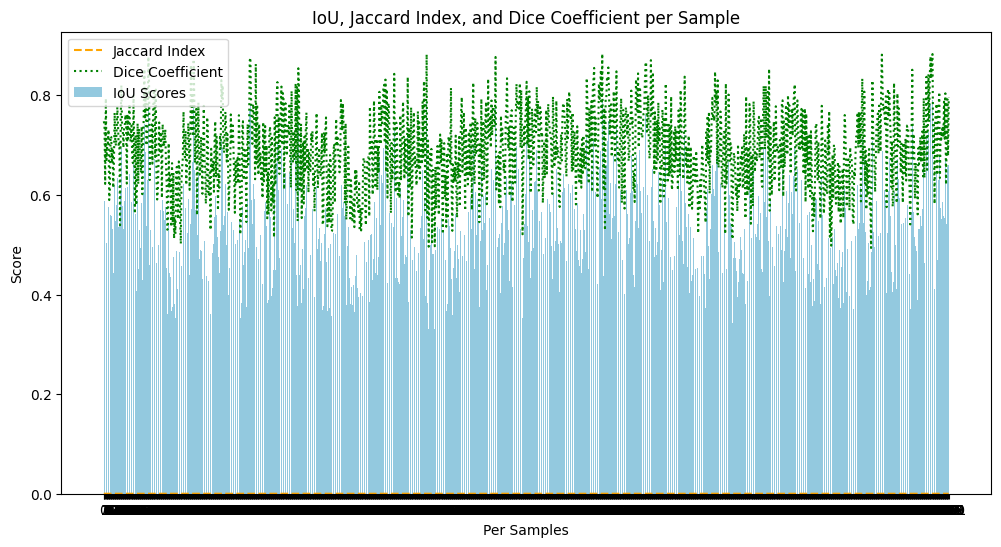

In [24]:
# Visualize IoU, Jaccard, and Dice scores with Seaborn
plt.figure(figsize=(12, 6))
sns.barplot(
    x=list(range(len(iou_scores))), 
    y=iou_scores, 
    color="skyblue", 
    label="IoU Scores"
)
sns.lineplot(
    x=list(range(len(jaccard_scores))), 
    y=jaccard_scores, 
    color="orange", 
    label="Jaccard Index", 
    linestyle="--"
)
sns.lineplot(
    x=list(range(len(dice_scores))), 
    y=dice_scores, 
    color="green", 
    label="Dice Coefficient", 
    linestyle=":"
)
plt.xlabel("Per Samples")
plt.ylabel("Score")
plt.title("IoU, Jaccard Index, and Dice Coefficient per Sample")
plt.legend()
plt.show()

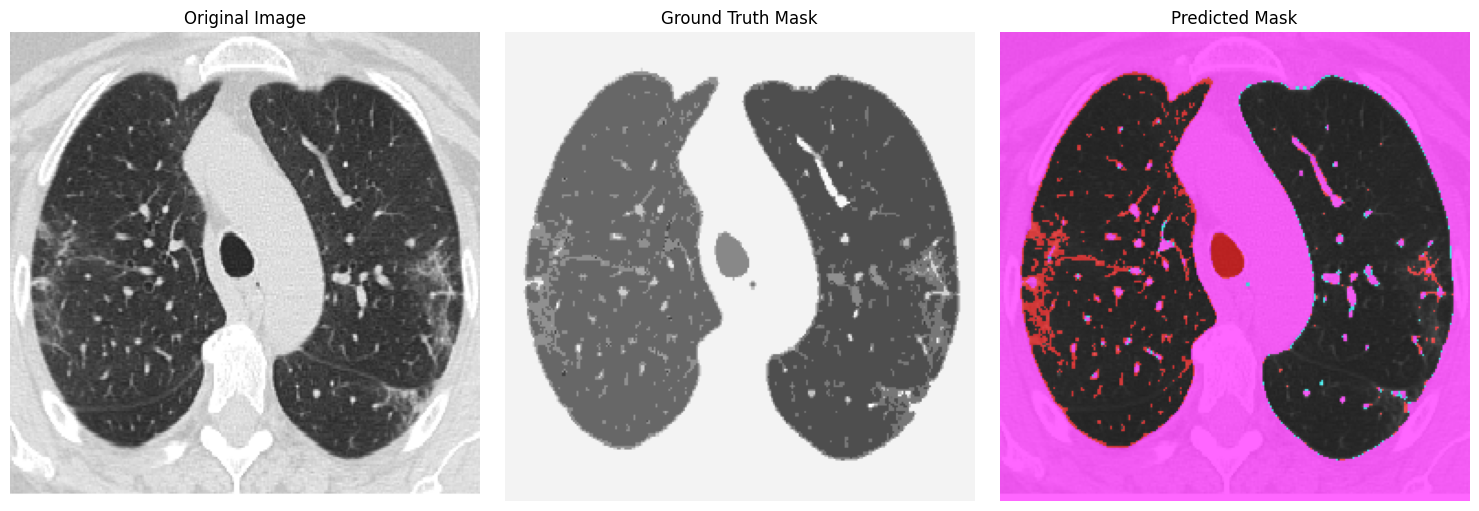

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize one of the predictions
def visualize_prediction(image, mask, pred_mask, threshold=0.5):
    """
    Visualize the original image, ground truth mask, and predicted mask with clear coloring:
    - Green: Dotted regions (lung without infection)
    - Red: Infected regions inside the lung
    - Yellow: General lung region
    """
    # Binary masks based on threshold
    lung_mask = (pred_mask.squeeze() > threshold).astype(np.float32)  # Entire lung region
    infected_mask = (mask.squeeze() > threshold).astype(np.float32)  # Ground truth infected area
    dotted_region_mask = lung_mask * (1 - infected_mask)  # Lung region excluding infected areas

    # Create a combined RGB mask for visualization
    overlay = np.zeros((*pred_mask.shape[:2], 3))  # Initialize RGB mask
    overlay[:, :, 0] = infected_mask  # Red channel for infected regions
    overlay[:, :, 1] = dotted_region_mask  # Green channel for dotted regions
    overlay[:, :, 2] = lung_mask  # Blue channel for the entire lung region

    # Normalize overlay to keep colors distinct
    overlay = overlay / overlay.max()

    # Plot the results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Original Image
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    # Ground Truth Mask
    axes[1].imshow(mask.squeeze(), cmap="gray", alpha=0.8)
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")

    # Predicted Mask with Overlay
    axes[2].imshow(image, alpha=0.8)  # Original image as background
    axes[2].imshow(overlay, alpha=0.6)  # Overlay the lung, dotted, and infected areas
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")

    # Show plot
    plt.tight_layout()
    plt.show()

# Visualize the first prediction
visualize_prediction(images[0], masks[0], predictions[0])
